# Transformer
The goal of this notebook is to create an educational implementation of the transformer with minimal dependencies that's easy to map to the paper.

### References
https://github.com/pytorch/examples/blob/main/word_language_model/

https://github.com/karpathy/nanoGPT/tree/master

In [1]:
import math
import requests
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Trying to avoid too many tricks and optimizations, but this makes a big difference on
# newer NVIDIA chips without breaking anything else. It allows torch to transparently
# use tf32 datatype in certain places.
if device == 'cuda':
    torch.set_float32_matmul_precision('high')

In [2]:
class Embeddings(nn.Module):
    def __init__(self, positions, vocab_size, dmodel, embs='sin'):
        super().__init__()
        self.word_embs = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=dmodel
        )

        self.embs = embs
        # This branch selects sinusoid embeddings like in the original paper
        if self.embs == 'sin':
            p_grid, i_grid = torch.meshgrid(
                torch.arange(positions),
                torch.arange(dmodel),
                indexing='ij'
            )
            self.register_buffer('pos_sin', torch.sin(p_grid / (10000**(2 * i_grid / dmodel))))
            self.register_buffer('pos_cos', torch.cos(p_grid / (10000**(2 * i_grid / dmodel))))
        # This selects learnable embeddings.
        else:
            self.learnable_embs = nn.Parameter(torch.randn(positions, dmodel))

    def forward(self, x):
        e = self.word_embs(x)
        if self.embs == 'sin':
            e = (e + self.pos_sin + self.pos_cos)
        else:
            e = e + self.learnable_embs
        return e

In [3]:
# Inputs q,k,v are positions x dk, or positions x dv
# Dot all q with k. One must be tranposed to make this line up
class SDPA(nn.Module):
    def __init__(self, causal, positions, dkv):
        super().__init__()
        self.pos = positions
        self.d = dkv
        self.causal = causal
        if causal:
            self.register_buffer('mask', torch.tril(torch.ones(self.pos, self.pos)).to(torch.bool))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, q, k, v):
        assert(self.d == k.shape[-1])
        q_dot_k = torch.bmm(q, (k.transpose(-2, -1)))
        scaled = q_dot_k / (math.sqrt(self.d))
        if self.causal:
            # Going into a softmax, we must assign -inf, not 0. If the incoming tensor has
            # both positive and negative values, a 0 in the softmax is going to be somewhere
            # in the middle, rather than 0 probability.
            scaled = scaled.masked_fill(~(self.mask), -float('inf'))
        logits = self.softmax(scaled)
        out = torch.bmm(logits, v)
        return out


In [4]:
class Head(nn.Module):
    def __init__(self, causal, positions, dkv, dmodel):
        super().__init__()
        self.v_projection = nn.Linear(dmodel, dkv)
        self.k_projection = nn.Linear(dmodel, dkv)
        self.q_projection = nn.Linear(dmodel, dkv)

        self.sdpa = SDPA(causal, positions, dkv)

    def forward(self, v, k, q):
        vp = self.v_projection(v)
        kp = self.k_projection(k)
        qp = self.q_projection(q)
        return self.sdpa(qp, kp, vp)

# dk = dv = dmodel/nhead
# wq is dmodel x dk
# wk is dmodel x dk
# wv is dmodel x dv
class MHA(nn.Module):
    def __init__(self, causal, positions, nhead, dmodel):
        super().__init__()
        assert(dmodel % nhead == 0)
        self.heads = nn.ModuleList([Head(causal, positions, dmodel//nhead, dmodel) for _ in range(nhead)])
        

        # TODO In the paper it's called WO, and hd_v x dmodel, but b/c d_v = dmodel/h it turns out to be square.
        self.out_projection = nn.Linear(dmodel, dmodel)

    def forward(self, v, k, q):
        head_outputs = [h(v, k, q) for h in self.heads]
        catd = torch.cat(head_outputs, dim=-1)
        
        projection = self.out_projection(catd)
        return projection

    def get_hook(self,name):
        def hook(model, input, output):
            self.attentions[f"head_{name}"] = output.detach()
        return hook
    
    def setup_attention_hook(self):
        self.attentions = {}
        self.hooks = []
        
        for i, head in enumerate(self.heads):          
            self.hooks.append(head.sdpa.softmax.register_forward_hook(self.get_hook(i)))
            

In [5]:
class FeedForward(nn.Module):
    def __init__(self, dmodel, ff, dropout=0.1):
        super().__init__()
        self.f0 = nn.Linear(dmodel, ff)
        self.f1 = nn.Linear(ff, dmodel)
        self.dropout = nn.Dropout(p=dropout)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.f0(x)
        x = self.act(x)
        x = self.f1(x)
        x = self.dropout(x)
        return x

# Input/Output are Batch, Positions, then Model Dimension.
class TransformerDecoder(nn.Module):
    def __init__(self, positions, dmodel, ff, nhead, dropout=0.1):
        super().__init__()
        self.mha0 = MHA(True, positions, nhead, dmodel)
        self.layernorm0 = nn.LayerNorm(dmodel)

        self.feedforward = FeedForward(dmodel, ff, dropout)
        self.layernorm2 = nn.LayerNorm(dmodel)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, inputs): 
        x = self.mha0(inputs, inputs, inputs)
        x = self.layernorm0(x + inputs)

        x_pre_ff = x
        x = self.feedforward(x)
        x = self.layernorm2(x + x_pre_ff)
        return x

In [6]:
class OutputProjection(nn.Module):
    def __init__(self, dmodel, vocab_size):
        super().__init__()
        self.proj = nn.Linear(dmodel, vocab_size)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.proj(x)

        # You'd expect a softmax here, but we're leaving it out and going to let CrossEntropyLoss handle it instead.
        return x

In [7]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, positions, dmodel, ff, nhead, nlayers, dropout=0.1):
        super().__init__()
        self.emb = Embeddings(positions, vocab_size, dmodel, embs='sin')
        self.transformer_layers = nn.ModuleList([TransformerDecoder(positions, dmodel, ff, nhead=nhead, dropout=dropout) for _ in range(nlayers)])
        self.out = OutputProjection(dmodel, vocab_size)

    def setup_attention_hook(self):
        for x in self.transformer_layers:
            x.mha0.setup_attention_hook()
            
    def forward(self, x):
        x = self.emb(x)
        for layer in self.transformer_layers:
            x = layer(x)

        x = self.out(x)
        return x

In [8]:
from torch.utils.data import Dataset, DataLoader, random_split

class TextfileDataset(Dataset):
    """ 
    Characterlevel dataset for the a generic textfile
    """

    def __init__(self, textfile='lorem_ipsum.txt', block_size=32):
        self.length = block_size

        with open(textfile, 'r') as f:
            self.text = f.read()

        self.unique_chars = set(self.text)
        self.vocab_size = len(self.unique_chars)

        # Characters to numbers
        self.encoding = {y: x for (x, y) in enumerate(self.unique_chars)}
        # Numbers to characters
        self.decoding = {x: y for (x, y) in enumerate(self.unique_chars)}

        self.text_encoded = torch.tensor([self.encoding[x] for x in self.text], dtype=torch.long)
        
    def __len__(self):
        return 10000  # Arbitrary, samples are random slices generated at every step.
    
    def get_vocab_size(self):
        return self.vocab_size
    
    def get_block_size(self):
        return self.length

    def __getitem__(self, idx):
        # Randomly select the part of the sequence we're going to use
        z = torch.randint(0, len(self.text) - self.length , (1,))
        start = z.item()
        
        inputs = self.text_encoded[start:start + self.length]
        targets = self.text_encoded[start + 1 :start + 1 + self.length]
        assert(len(targets) == self.length)
        return inputs, targets


In [9]:
# The dataset used in minGPT, nanoGPT.
# You can have it learn a different dataset by supplying your own text file and pointing the TextfileDataset
# constructor to it in the next cell.
if not os.path.exists('shakespeare.txt'):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open('shakespeare.txt', 'w') as f:
        f.write(requests.get(data_url).text)

In [10]:
if device == 'cuda':
    dmodel = 384
    ff = 4 * dmodel
    heads_per_layer = 6
    layers = 6
    batchsize = 64
    length = 256
else: # Smaller model for CPU training
    dmodel = 128
    ff = 4 * dmodel
    heads_per_layer = 4
    layers = 4
    batchsize = 16
    length = 64
    

# Load your own large txt file here. For instance, the works of shakespeare used in Karpathy's examples.
dset = TextfileDataset(textfile='shakespeare.txt', block_size=length)
print("Dset has {} samples".format(len(dset)))

# Again, arbitrary choice of split. Because of the way our dataloader draws both train/valid samples
# from the same text, this has no real effect.
dset_train, dset_valid = random_split(dset, [0.9, 0.1])

train_loader = DataLoader(dset_train, batch_size=batchsize, num_workers=16, shuffle=True)
test_loader = DataLoader(dset_valid, batch_size=batchsize, num_workers=16, shuffle=True)

positions = dset.get_block_size()
vocab_size = dset.get_vocab_size()

# Print some samples from the dataset
# for x,y in dset:
#     print('=====================================')
#     print(''.join([dset.decoding[z] for z in x]))

print(f"Model with context size of {positions} and vocab size of {vocab_size}")
model = Transformer(vocab_size, positions, dmodel, ff, heads_per_layer, layers, 0.1).to(device)

# Comment if this breaks on your setup, it's for performance.
# model = torch.compile(model)

epochs = 50
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

lossfn = nn.CrossEntropyLoss()

Dset has 10000 samples
Model with context size of 256 and vocab size of 65


In [11]:
loss_plot = []
for epoch in range(epochs):
    begin = time.time()
    model.train()
    
    for i, (text, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outs = model(text.to(device))

        # We're only calculating loss on the last model index.
        # Also `target` can be passed as just token ids because CrossEntropyLoss will expand
        # it into a onehot vector for you. 
        loss = lossfn(outs[:, -1, :], target[:, -1].to(device))
        loss.backward()
        optimizer.step()

    # Even though the test_loader gives us samples from the same place, doing a second eval
    # run is still different because the dropoff layers are disabled.
    losses = []
    model.eval()
    with torch.no_grad():
        for i, (text, target) in enumerate(test_loader):
            outs = model(text.to(device))
            loss = lossfn(outs[:, -1, :], target[:, -1].to(device))
            losses.append(loss)
    elapsed = time.time() - begin
    epoch_loss = torch.Tensor(losses).mean().item()
    print("Epoch {} took {:.2f}s, Current loss is {}".format(epoch, elapsed, epoch_loss))
    loss_plot.append(epoch_loss)


Epoch 0 took 7.87s, Current loss is 2.6734542846679688
Epoch 1 took 7.72s, Current loss is 2.5830211639404297
Epoch 2 took 7.65s, Current loss is 2.582180976867676
Epoch 3 took 7.57s, Current loss is 2.587582588195801
Epoch 4 took 7.66s, Current loss is 2.458186626434326
Epoch 5 took 7.56s, Current loss is 2.327765703201294
Epoch 6 took 7.77s, Current loss is 2.3533873558044434
Epoch 7 took 7.67s, Current loss is 2.316941022872925
Epoch 8 took 7.67s, Current loss is 2.2797818183898926
Epoch 9 took 7.67s, Current loss is 2.245791435241699
Epoch 10 took 7.68s, Current loss is 2.1198930740356445
Epoch 11 took 7.67s, Current loss is 2.2803215980529785
Epoch 12 took 7.70s, Current loss is 2.112736940383911
Epoch 13 took 7.69s, Current loss is 2.1196210384368896
Epoch 14 took 7.68s, Current loss is 2.0968003273010254
Epoch 15 took 7.94s, Current loss is 2.0808467864990234
Epoch 16 took 7.82s, Current loss is 2.0392143726348877
Epoch 17 took 7.75s, Current loss is 1.913948893547058
Epoch 18 t

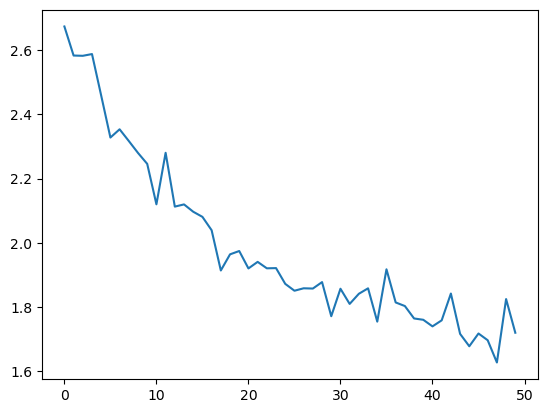

In [12]:
import matplotlib.pyplot as plt
plt.plot(loss_plot)

In [13]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

model.eval()
model.setup_attention_hook()
# Start by grabbing a sample from the validation set
buf, _ = dset_valid[0]
print(bcolors.OKCYAN, ''.join([dset.decoding[x] for x in buf.numpy()]), bcolors.WARNING, sep='', end='')
with torch.no_grad():
    for x in range(length):
        a = buf[None].to(device)
        out = model(a)

        # The prediction is the last token in the output vec, grab that and add it to the context
        pred = F.softmax(out[0, -1, :], dim=-1)
        pred = torch.multinomial(pred, num_samples=1).cpu()
        print(dset.decoding[pred.item()], end='')
        # Then drop the oldest token and keep going until we completely replaced the input.
        buf = torch.concatenate((buf, pred))[1:]
    


For many men that stumble at the threshold
Are well foretold that danger lurks within.

KING EDWARD IV:
Tush, man, abodements must not now affright us:
By fair or foul means we must enter in,
For hither will our friends repair to us.

HASTINGS:
My liege, if indeap troupling ap chelor
From my brown, sing;-dow your thy faithbate!
Now's with batrre one a have to lands?
Second my eorkel trust have that and possrow
't horselves thou, though bring bleare'd.
Well, I'll twoods might their you of yout,
I will world

In [14]:
import itertools
maps = {}
for layer, head in itertools.product(range(layers), range(heads_per_layer)):
    maps[(layer, head)] = model.transformer_layers[layer].mha0.attentions[f"head_{head}"].squeeze()

Plot attention maps from the first (shallowest) layer.

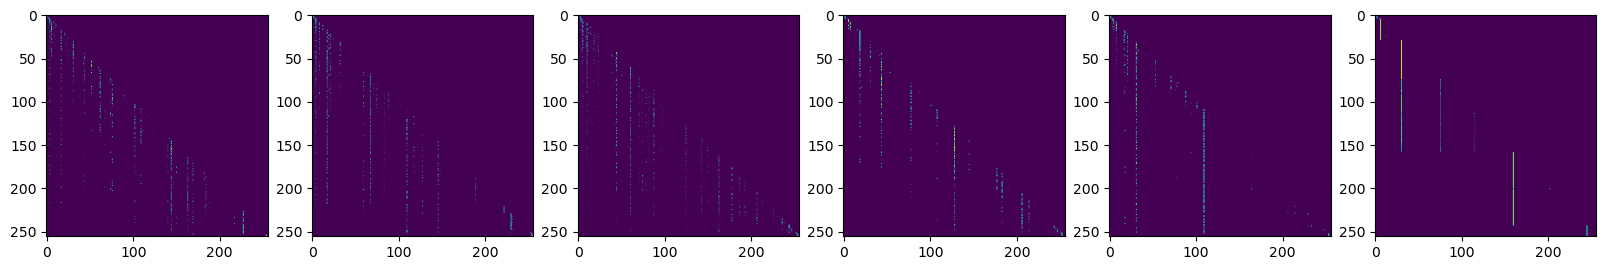

In [15]:
import matplotlib.pyplot as plt
# Layers vertically, heads horizontally.
fig, axs = plt.subplots(1, heads_per_layer, figsize=(20,5))
for h in range(heads_per_layer):
    axs[h].imshow(maps[(0,h)].abs().cpu().numpy())